In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
 import ast
from build import item
from build import build
from build.config import dmg
import utils.skillpoints as sp
from utils import dmgcalc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np

In [15]:
def get_data(weapon, file):
    with open(file, 'r') as f:
        lines = f.readlines()
    score = []
    real = []
    builds = []
    reqsps = []
    bonsps = []
    freesp = []
    
    for i, text in enumerate(lines):
        data = ast.literal_eval(text)
        if 'Cinderchain' in data[0] and 'Dupliblaze' in data[0]:
            continue
        real.append(data[1])
        score.append(data[2])
    
        items = [item.get_item(n) for n in data[0]]
        b = build.Build(weapon, *items)
        reqsp, bonsp = b.calc_sp()
        reqsps.append(reqsp)
        bonsps.append(bonsp)
        freesp.append(204-sum(reqsp))
    
        builditem = sp.add_sp(b.build(), *b.calc_sp())
        for t,m in zip(dmgcalc.damageTypes, dmg.mastery):
            builditem.identifications[t] += 15*m
        builds.append(builditem)
    return (score, real, builds, reqsps, bonsps, freesp)
    
def plot2D(x, y, r=None, bins=None, xlabel='x', ylabel='y'):
    if r is None:
        r = [[min(x),max(x)],[min(y),max(y)]]
    if bins is None:
        bins=(100,100)
    plt.hist2d(x, y, bins=bins, cmap='jet', norm=colors.LogNorm(), range = r)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def normalise(data):
    m = min(data)
    d = 1/(max(data)-min(data))
    return [(x-m)*d for x in data]

def plot3D(x,y,z,bins=(25,25,100),xlabel='x',ylabel='y',zlabel='z'):
    hist, edges = np.histogramdd((x,y,z), bins=bins)
    mids = []
    for edge in edges:
        mid = []
        for i in range(len(edge)-1):
            mid.append((edge[i+1] + edge[i])/2)
        mids.append(mid)
    
    x = []
    y = []
    z = []
    density = []
    for i,a in enumerate(mids[0]):
        for j,b in enumerate(mids[1]):
            for k,c in enumerate(mids[2]):
                if hist[i,j,k] != 0:
                    x.append(a)
                    y.append(b)
                    z.append(c)
                    density.append(hist[i,j,k])
                    
    mlab.figure('DensityPlot')
    mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.02)
    mlab.axes(xlabel='score',ylabel='sp',zlabel='real')
    mlab.show()

elements = ['neutral', 'earth', 'thunder', 'water', 'fire', 'air']
Elements = ['Neutral', 'Earth', 'Thunder', 'Water', 'Fire', 'Air']
damageTypes = ["damage", "earthDamage", "thunderDamage",  "waterDamage", "fireDamage", "airDamage"]
def data_to_pandas(weapon,data):
    mastery = [False, False, True, False, False]
    spellmod = [0.3, 0, 0.15, 0.1, 0, 0]
    base_dmg_max, base_dmg_min = dmgcalc.base_dmg(weapon, spellmod, mastery)
    relevant_ids = ["rawStrength", "rawDexterity", "rawIntelligence", "rawDefence", "rawAgility", 'rawSpellDamage',
                    'spellDamage', "elementalDamage", "rawElementalDamage", "rawElementalSpellDamage", "elementalSpellDamage"]
    for i in range(6):
        if base_dmg_max[i] > 0:
            relevant_ids += [damageTypes[i], elements[i]+'SpellDamage', 'raw'+Elements[i]+'Damage', 'raw'+Elements[i]+'SpellDamage']
    df = pd.DataFrame({'score':data[0],'real':data[1],'reqsp':data[3],'bonsp':data[4],'freesp':data[5]})
    for i in relevant_ids:
        df[i] = [it.identifications[i].max for it in data[2]]
    
    return df

In [37]:
nirvana = item.get_weapon('Nirvana').set_powders(["w", "w", "w"])
nirvdata = get_data(nirvana, 'output/Nirvana401451.txt')
nirvdf = data_to_pandas(nirvana,nirvdata)

In [85]:
cataclysm = item.get_weapon("Cataclysm").set_powders(["t", "t", "t"])
catadata = get_data(cataclysm, 'output/Cataclysm493678.txt')
catadf = data_to_pandas(cataclysm,catadata)

In [ ]:
oblivion = item.get_weapon("Oblivion").set_powders(["t", "t", "t", "t"])
oblidata = get_data(oblivion, 'output/Oblivion42742.txt')
oblidf = data_to_pandas(oblivion,oblidata)

In [ ]:
inferno = item.get_weapon("Inferno").set_powders(["f", "f", "f"])
infdata = get_data(inferno,'output/results.txt')
infdf = data_to_pandas(inferno,infdata)

In [ ]:
cutdf = infdf.query('rawStrength<150 & rawDexterity<150')
print(infdf.shape[0], cutdf.shape[0])

f = 1
evalstr = f'{f}*(rawDefence)'
x = cutdf.eval(evalstr)
y = cutdf['real']
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[y.iloc[-100],y.iloc[0]]]

plt.figure(figsize=(12,8))
plot2D(x,y,r=r,xlabel=evalstr,ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')
plt.show()

In [ ]:
cutdf = infdf2.query('rawStrength<150 & rawDexterity<150')
print(oblidf.shape[0], cutdf.shape[0])

y = cutdf['real']
cutdf.eval('sumsp = rawStrength + rawDexterity', inplace=True)
for col in ['sumsp']:
    if col in ['reqsp','bonsp']:
        continue
    amounts = []
    for f in np.linspace(1,3,81):
        x = cutdf.eval(f'{f}*{col} + score')
        threshold = min(x[0:100])
        #print(f, len([i for i in x if threshold <= i]))
        amounts.append(len([i for i in x if threshold <= i]))
    f = np.linspace(1,3,81)[np.argmin(amounts)]
    x = cutdf.eval(f'{f}*{col} + score')
    threshold = min(x[0:100])
    threshold2 = max(x[0:100])
    print(col, f, threshold, len([i for i in x if threshold <= i <= threshold2]))
    
    r = [[min(x[-200:-100]),max(x)],[y.iloc[-100],y.iloc[0]]]
    print(r)
    
    plt.figure(figsize=(12,8))
    plot2D(x,y,r=r,xlabel=f'{f}*{col} + score',ylabel='real dmg')
    plt.axvline(threshold,color='b')
    plt.axvline(threshold2,color='b')
plt.show()

In [ ]:
df = catadf
tot = df.shape[0]
for col in df.columns:
    if col in ['reqsp','bonsp']:
        continue
    print(col, min(df[col]), max(df[col]))
    threshold = min(df[col].iloc[0:100])
    print(threshold, round(df.query(f'{col}>={threshold}').shape[0]/tot,3))
    threshold2 = max(df[col].iloc[0:100])
    print(threshold2, round(df.query(f'{col}<={threshold2}').shape[0]/tot,3))

95.0 237043
140.0 453746
235.0 234086


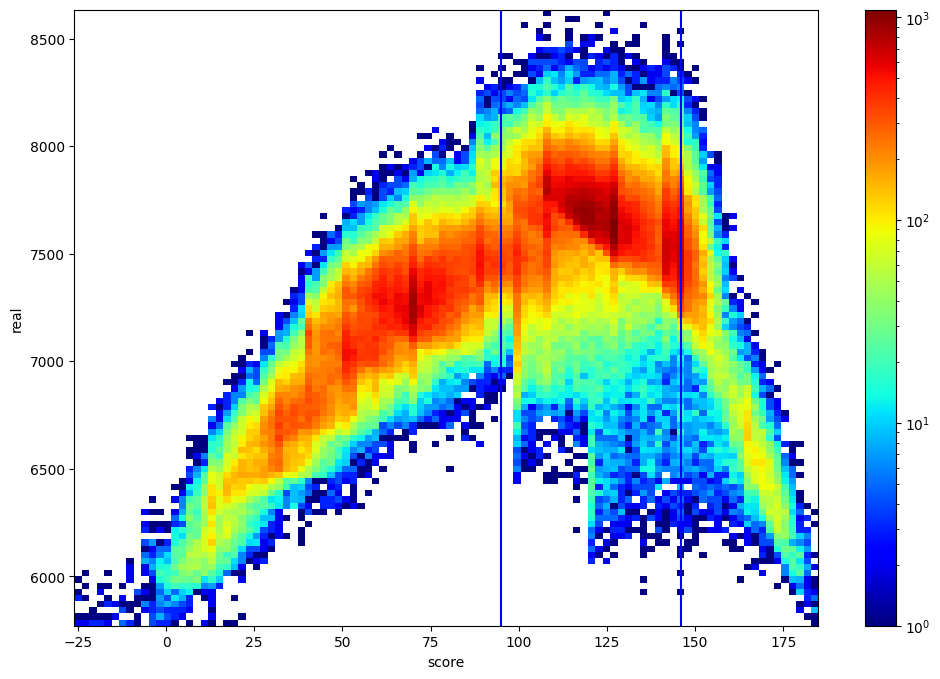

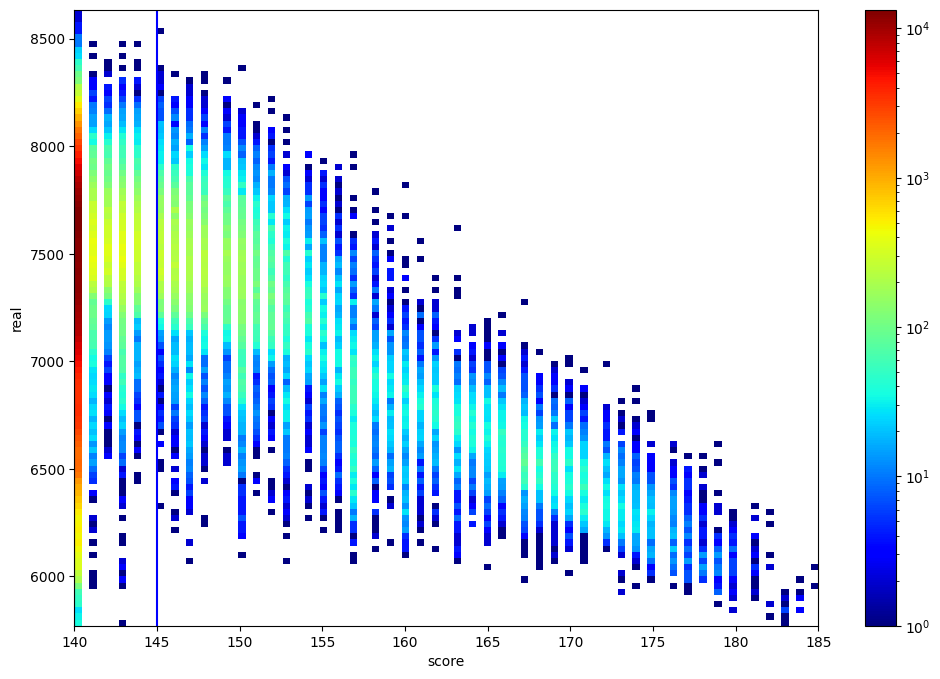

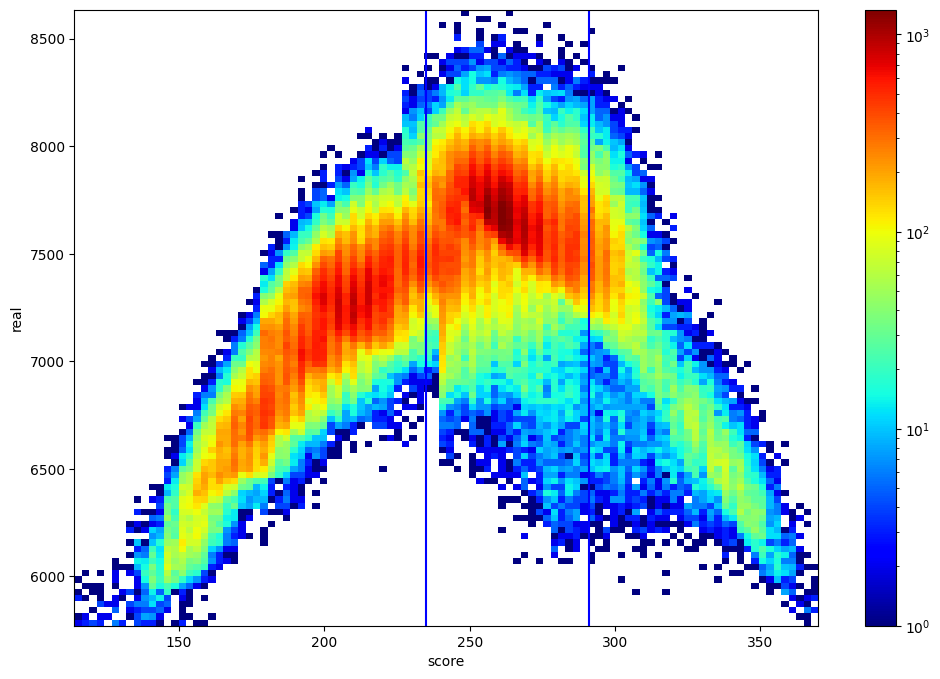

In [58]:
#scores, reals, builds = nirvdata[0:3]
scores, reals, builds = catadata[0:3]

spsum = [i.identifications['rawStrength'].max + i.identifications['rawDexterity'].max for i in builds]

factor = 2.42
x = [(1*i.identifications['rawStrength'].max + 0*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')


x = [(0*i.identifications['rawStrength'].max + 1*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')

x = [(1*i.identifications['rawStrength'].max + 1*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')

In [ ]:
infdf.head(10)

In [ ]:
print(inferno.requirements)